---
title: "2023_Kronensicherung_Plesse_Analyse_Schwingungen_Integrale"
author: "Kyell Jensen"
date: "2024-08-06"
format: pdf
editor: visual
---

# 2023_Kronensicherung_Plesse_Analyse_Schwingungen_Integrale

## Kombinierte Analyse LineScale3, TreeQinetic und Versuchsaufzeichung

Nutze eine geeignete Python 3.11 Umgebung (z. B. virtuelle Environment).

## Arbeitsumgebung vorbereiten

### IMPORT: Packages

In [1]:
# Struktur & Typen
from pathlib import Path
from typing import Dict, List

# Datenverarbeitung
import json
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
from slugify import slugify  # Zum Vereinheitlichen von Strings

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown, display

# Statistik
from scipy.stats import linregress, f_oneway
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as mc

In [2]:
# Eigene Module und Funktionen
from kj_core.utils.latex_export import (
    generate_latex_table,
    generate_grouped_latex_tables,
    save_latex_table,
    build_data_dict_df
)
from kj_core.utils.labeling import (
    get_label_from_dict,
    get_color_dict
)
from kj_core import (
    CoreConfig,
    PlotManager,
    get_logger
)

# Projekteinstellungen
from project_config import (
    working_directory,
    data_export_directory,
    latex_export_directory,
    filename_clean_dataset,
    filename_clean_data_dict
)

### IMPORT: Manager Instanzen

In [3]:
logger = get_logger(__name__)
CONFIG = CoreConfig(working_directory=f"{working_directory}/combined")
PLOT_MANAGER = PlotManager(CONFIG)

2025-08-26 15:57:00 [WARNING] kj_core.core_config.set_working_directory: The directory C:\kyellsen\005_Projekte\2024_BA\032_Feldversuch_2023_Plesse\030_Analysen\2023_Kronensicherung_Plesse_Kraefte_Schwingungen\working_directory\combined already exists.
2025-08-26 15:57:00 [INFO] kj_core.core_config.set_working_directory: Working directory set to C:\kyellsen\005_Projekte\2024_BA\032_Feldversuch_2023_Plesse\030_Analysen\2023_Kronensicherung_Plesse_Kraefte_Schwingungen\working_directory\combined!
2025-08-26 15:57:00 [INFO] kj_core.core_config.__init__: <CoreConfig>
  Package:            kj_core
  Working Directory:  C:\kyellsen\005_Projekte\2024_BA\032_Feldversuch_2023_Plesse\030_Analysen\2023_Kronensicherung_Plesse_Kraefte_Schwingungen\working_directory\combined
  Plot Directory:     C:\kyellsen\005_Projekte\2024_BA\032_Feldversuch_2023_Plesse\030_Analysen\2023_Kronensicherung_Plesse_Kraefte_Schwingungen\working_directory\combined\plots
  Data Directory:     C:\kyellsen\005_Projekte\2024

## IMPORT: Daten Import

In [4]:
# Dateien laden
df = pd.read_feather(data_export_directory / filename_clean_dataset)

with open(data_export_directory / filename_clean_data_dict, "r", encoding="utf-8") as f:
    data_dict = json.load(f)

## ANALYSE: Explorative Datenanalyse

In [5]:
df.head(3)

,id,rope_datetime,treatment,release_force_target,rope_release,cable_max_force,cable_integral,sensor_name,location,direction,...,frequency_damped,phase_angle,y_shift,x_shift,frequency_undamped,damping_ratio,metrics_warning,pearson_r,nrmse,nmae
4,2,2022-03-23 11:24:23,free,2.8,2.7231,NaN,0.0,Elasto(90),StB,elongation,...,0.441518,0.2,-5.287164,0.116641,0.442936,0.503994,False,0.943158,0.038866,0.018011
5,2,2022-03-23 11:24:23,free,2.8,2.7231,NaN,0.0,Elasto(92),StB,elongation,...,0.432441,-0.2,-14.233644,-0.009730,0.436601,0.873595,False,0.929554,0.034560,0.016183
6,2,2022-03-23 11:24:23,free,2.8,2.7231,NaN,0.0,Elasto(95),StA,elongation,...,0.422702,-0.2,-19.011309,-0.123043,0.426319,0.823807,False,0.908058,0.044873,0.024274


In [6]:
df.columns

Index(['id', 'rope_datetime', 'treatment', 'release_force_target',
       'rope_release', 'cable_max_force', 'cable_integral', 'sensor_name',
       'location', 'direction', 'height', 'diameter', 'max_strain',
       'max_compression', 'integral_intercept', 'integral_positiv',
       'integral_negativ', 'integral_abs', 'integral_ratio', 'm_amplitude',
       'm_amplitude_2', 'initial_amplitude', 'damping_coeff',
       'frequency_damped', 'phase_angle', 'y_shift', 'x_shift',
       'frequency_undamped', 'damping_ratio', 'metrics_warning', 'pearson_r',
       'nrmse', 'nmae'],
      dtype='object')

### COMBINED: Definition von Darstellungsstandards
Festlegen von Farbcodes für einheitliche Darstellung von Sensoren und Behandlungsvarianten für alle nachfolgenden Plots.

In [7]:
color_palette = PLOT_MANAGER.color_palette_list

# Für die Spalte "treatment":
treatment_color_dict = get_color_dict(df, "treatment", PLOT_MANAGER.color_palette_list)

Index(['free', 'gefa_dynamic', 'cobra_static'], dtype='object')


### LS3 ANALYSE: Zusammenhang Vorspannung und Lastspitze KS

In [8]:
# Funktion zur Erstellung des Text-Strings für die statistischen Parameter
def annotate_stats(x, y):
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    text_str = f"R = {r_value:.4f}\nSlope = {slope:.4f}\nIntercept = {intercept:.2f}\np-value = {p_value:.2e}\nStd Err = {std_err:.2f}"
    return text_str

In [9]:
df_grouped_by_id = (
    df[['id', 'treatment', 'release_force_target', 'rope_release', 'cable_max_force', 'cable_integral', 'integral_abs', 'integral_ratio']]
    .groupby('id', observed=False)
    .agg(
        treatment            = ('treatment',        'first'),
        #release_force_target = ('release_force_target','first'),
        #rope_release         = ('rope_release',     'first'),
        #cable_max_force            = ('cable_max_force',        'first'),
        cable_integral       = ('cable_integral',   'first'),
        integral_abs         = ('integral_abs',     'mean'),
    )
    .reset_index()
)
df_grouped_by_id

,id,treatment,cable_integral,integral_abs
0,2,free,0.000000,397.570305
1,3,free,0.000000,524.217256
2,4,free,0.000000,561.349298
3,5,free,0.000000,436.829067
4,6,free,0.000000,532.814491
5,7,free,0.000000,454.774248
6,8,free,0.000000,494.802813
7,9,free,0.000000,467.805947
8,10,free,0.000000,488.462761
9,11,gefa_dynamic,1.114957,361.969600


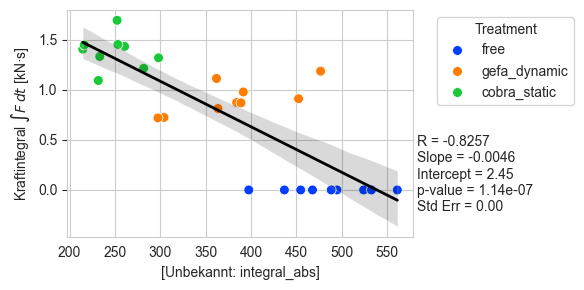

In [10]:
data_df = df_grouped_by_id
x_var = 'integral_abs'
y_var = 'cable_integral'

fig, ax1 = plt.subplots(figsize=(6, 3))
sns.scatterplot(data=data_df, x=x_var, y=y_var, hue='treatment', palette=treatment_color_dict, ax=ax1, s=50, edgecolor='w')
sns.regplot(data=data_df, x=x_var, y=y_var, ax=ax1, scatter=False, ci=95, color='black', line_kws={'lw': 2})
ax2 = ax1.twinx(); ax2.axis('off')
stats_text = annotate_stats(data_df[x_var], data_df[y_var])
ax2.annotate(stats_text, xy=(1.01, 0.1), xycoords='axes fraction', ha='left', va='bottom')
ax1.set_xlabel(get_label_from_dict(x_var, data_dict, use_full=True)); ax1.set_ylabel(get_label_from_dict(y_var, data_dict, use_full=True))
ax1.legend(title='Treatment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout(); plt.show()
PLOT_MANAGER.save_plot(fig, filename=f"{x_var}_vs_{y_var}", subdir="ls3_regression")

C:\Users\mail\AppData\Local\Temp\ipykernel_23476\1513403696.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='treatment', y='integral_ratio', palette=treatment_color_dict, ax=ax)


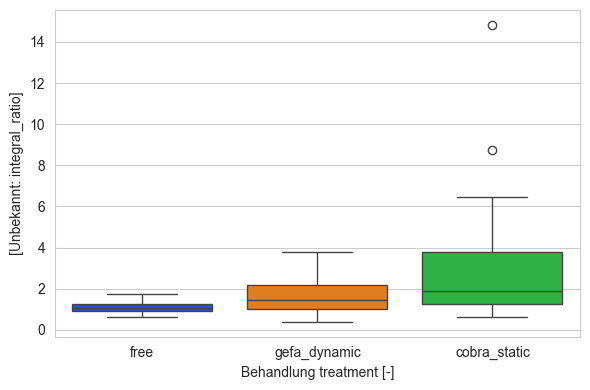

In [11]:
# assume df has columns 'treatment' and 'integral_ratio'
fig, ax = plt.subplots(figsize=(6, 4))
sns.boxplot(data=df, x='treatment', y='integral_ratio', palette=treatment_color_dict, ax=ax)
ax.set_xlabel(get_label_from_dict('treatment', data_dict, use_full=True))
ax.set_ylabel(get_label_from_dict('integral_ratio', data_dict, use_full=True))
plt.tight_layout()
plt.show()

PLOT_MANAGER.save_plot(fig, filename='integral_ratio_by_treatment', subdir='ls3_boxplots')